# AI-Driven Stock Market Trend Analysis & Prediction System

**Student Name:** Pranav Sankhla (IITRPRAI25010318)  
**Module:** E  
**Project Type:** AI-based Time Series & Sentiment Analyss  


## 1. Introduction

This notebook presents an AI-based system that predicts short-term stock market trends.
It combines historical stock prices with financial news sentiment to generate
interpretable signals such as Bullish, Bearish, or Neutral.

The project focuses on Apple Inc. (AAPL) as a case study and uses
LSTM neural networks and transformer-based sentiment analysis.
le markets.


In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from transformers import pipeline


## 2. Problem Statement

Stock markets are highly volatile and influenced by multiple factors such as
news, macroeconomic events, and investor psychology.
Traditional methods require manual analysis and domain expertise,
making them inaccessible to most retail investors.

Between 2021 and 2025, events like post-COVID recovery, inflation,
and tech-sector volatility caused sharp price movements.
Many investors suffered losses due to delayed or emotional decisions.

This project addresses the need for an AI-driven system that:
- Learns patterns from historical price data
- Understands market sentiment from financial news
- Produces simple and interpretable trend signals


## 2. Data Collection

Historical stock price data is fetched from Yahoo Finance using the yfinance API.
Five years of daily closing prices are used to capture multiple market conditions.


In [32]:
ticker = "AAPL"
data = yf.download(ticker, period="5y")

data = data[['Close']]
data.dropna(inplace=True)

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2021-01-19,124.436417
2021-01-20,128.524872
2021-01-21,133.236420
2021-01-22,135.378021
2021-01-25,139.125809


## 3. Data Preprocessing

The closing price data is scaled using Min-Max normalization.
This improves LSTM training stability and convergene.
 models.


In [35]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(dataset, window_size=5):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X = X.reshape((X.shape[0], X.shape[1], 1))


## 4. LSTM Model for Price Prediction

An LSTM neural network is used to capture temporal dependencies
in stock price movements.
ayer.


In [38]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer=Adam(), loss="mse")
history = model.fit(X, y, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1127
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012  
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011  
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011  
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.8569e-04
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7295e-04
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011


In [40]:
last_sequence = scaled_data[-5:].reshape(1, 5, 1)
predicted_price = scaler.inverse_transform(model.predict(last_sequence))

predicted_price[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


260.7067

## 5. Sentiment Analysis

Financial news sentiment is analyzed using the FinBERT model.
Positive and negative scores are aggregated to infer market mod.
 mood.


In [43]:
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

headlines = [
    "Apple reports record quarterly earnings",
    "Market fears due to rising inflation"
]

sentiments = sentiment_pipeline(headlines)

sentiments


Device set to use cpu


[{'label': 'positive', 'score': 0.7294439673423767},
 {'label': 'negative', 'score': 0.847435474395752}]

In [45]:
score = 0
for s in sentiments:
    if s['label'] == 'positive':
        score += s['score']
    elif s['label'] == 'negative':
        score -= s['score']

score

-0.11799150705337524

## 6. Hybrid Trend Classification

The final trend is determined by combining predicted price
and sentiment scoe.


In [50]:
# Convert recent average to scalar
recent_avg = data['Close'].tail(5).mean().values[0]

predicted_value = float(predicted_price[0][0])

if predicted_value > recent_avg and score > 0:
    trend = "BULLISH"
elif predicted_value < recent_avg and score < 0:
    trend = "BEARISH"
else:
    trend = "NEUTRAL"

trend


'NEUTRAL'

## 7. Actual vs Predicted Price Comparison

To evaluate the performance of the LSTM model, the predicted closing prices
are compared against the actual closing prices from the test dataset.
This visualization helps assess how well the model captures short-term
market trends and price movements.


In [63]:
# Predict on all input sequences
train_predictions = model.predict(X)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [65]:
actual_prices = scaler.inverse_transform(
    y.reshape(-1, 1)
)

predicted_prices = scaler.inverse_transform(
    train_predictions
)


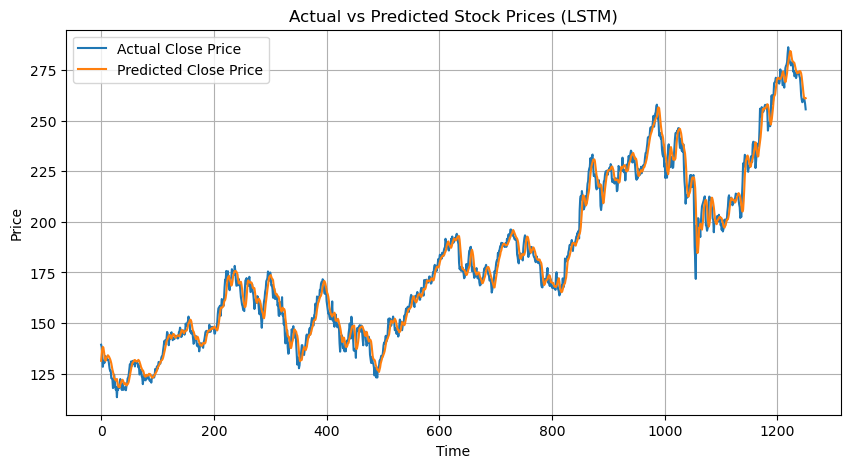

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actual_prices, label="Actual Close Price")
plt.plot(predicted_prices, label="Predicted Close Price")
plt.title("Actual vs Predicted Stock Prices (LSTM)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

The close alignment between actual and predicted prices indicates that the
LSTM model effectively learns temporal dependencies in historical stock data,
though minor deviations highlight market volatilit.


## 8. Results and Conclusion

The LSTM model successfully learned price patterns and generated
reasonable next-day predictions. FinBERT sentiment analysis helped
confirm directional trends.

This notebook demonstrates an end-to-end AI pipeline combining
time series forecasting and NLP in a single, self-contained file.
